<a href="https://colab.research.google.com/github/taravatp/Panopic-Feature-Pyramid-Network/blob/main/generate_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/panoptic_FPN

/content/drive/MyDrive/panoptic_FPN


In [ ]:
!pip install import_ipynb 

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=2cf772f46578e03d394450a278f90079fe94c7fd832d6b4bc4b4529911230a59
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

import import_ipynb
import time

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:',device)

device: cuda


# Generating semantic segmentation results

In [ ]:
from coco_semantic_dataset import coco_semantic_dataset
from models.semantic_model import SemanticSegmentationModel

importing Jupyter notebook from coco_semantic_dataset.ipynb
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 10.9 MB 24.5 MB/s 
     |████████████████████████████████| 58 kB 5.3 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 217 kB 43.0 MB/s 
     |████████████████████████████████| 51 kB 5.7 MB/s 
importing Jupyter notebook from /content/drive/MyDrive/panoptic_FPN/models/semantic_model.ipynb
device: cuda


In [ ]:
#loading the model
model_path = '/content/drive/MyDrive/panoptic_FPN/trained_models/semantic2/semantic_model31_batch_8.pth'
semantic_model = SemanticSegmentationModel(92).to(device)
semantic_model.load_state_dict(torch.load(model_path))
print('model loaded!')

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

model loaded!


In [ ]:
def get_prediction_semantic(model,dataset,index):

  image ,segmentation_mask = dataset[index]

  plt.figure(figsize=(10,20))
  plt.subplot(131)
  plt.imshow(image.numpy().transpose(1,2,0)) #channels come last
  plt.title('input image')

  plt.subplot(132)
  plt.imshow(image.numpy().transpose(1,2,0)) #channels come last
  plt.imshow(segmentation_mask.numpy(), alpha=0.9)
  plt.title("Ground truth")

  plt.subplot(133)
  plt.imshow(image.numpy().transpose((1,2,0)))
  with torch.no_grad():
    image = image[None,:] #adding a new dimmesnion / (batchsize/numclasses/height/width)
    preds = semantic_model(image.to(device)) #preds will be (1x92x640x480)

  preds = torch.squeeze(preds) #preds will be (92x640x480)
  preds = torch.argmax(preds,dim=0) #preds will be (640x480)
  preds = preds.cpu().numpy()

  plt.imshow(preds, alpha=0.9)
  plt.title('prediction')
  plt.show()

  return image ,segmentation_mask ,preds #returning the original image, ground-truth image and predictions

loading annotations into memory...
Done (t=2.50s)
creating index...
index created!
loading annotations into memory...
Done (t=1.75s)
creating index...
index created!


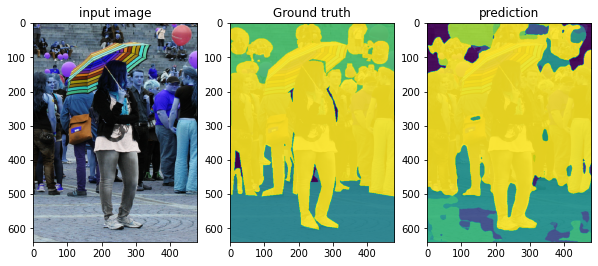

In [ ]:
dataset_test_semantic = coco_semantic_dataset(flag='test')
image ,segmentation_mask,preds = get_prediction_semantic(semantic_model,dataset_test_semantic,50)

# Generating Instance segmentation results

In [ ]:
from coco_instance_dataset import coco_instance_dataset
from models.instance_model import get_model_instance_segmentation

importing Jupyter notebook from coco_instance_dataset.ipynb
importing Jupyter notebook from /content/drive/MyDrive/panoptic_FPN/models/instance_model.ipynb


In [ ]:
#loading the model
model_path = '/content/drive/MyDrive/panoptic_FPN/trained_models/instance_Model4_batch_2.pth'
instance_model = get_model_instance_segmentation(81).to(device)
instance_model.load_state_dict(torch.load(model_path))
print('model loaded!')

In [ ]:
def get_prediction_instance(model,dataset,index,MASK_THRESHOLD=0.5):

  image,target = dataset[index]

  plt.figure(figsize=(10,20))

  plt.subplot(131)
  plt.imshow(image.numpy().transpose(1,2,0))
  plt.title('input image')

  height,width = target['masks'].shape[1],target['masks'].shape[2]

  masks = np.zeros((height,width))
  
  for i,mask in enumerate(target['masks']):
    mask = mask.numpy() 
    masks = masks + np.logical_or(mask,masks)

  plt.subplot(132)
  plt.imshow(image.numpy().transpose(1,2,0))
  plt.imshow(masks, alpha=0.9)
  plt.title("Ground truth")

  #print(target['labels'])
  instance_model.eval()
  with torch.no_grad():
      preds = instance_model([image.to(device)])[0]
  
  plt.subplot(133)
  plt.imshow(image.cpu().numpy().transpose((1,2,0)))
  all_preds_masks = np.zeros((height,width))
    
  for i,mask in enumerate(preds['masks'].cpu().detach().numpy()):
    if preds['scores'][i] > 0.3:
      all_preds_masks = all_preds_masks + np.logical_or(all_preds_masks, mask[0] > MASK_THRESHOLD)
  plt.imshow(all_preds_masks, alpha=0.9)
  plt.title("Predictions")
  plt.show()

  return image,target,preds

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


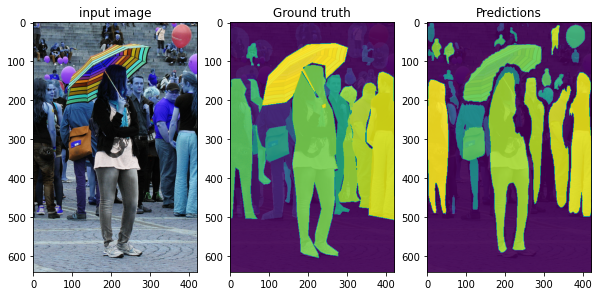

In [ ]:
dataset_test_instance = coco_instance_dataset(flag='test')
image,target,preds = get_prediction_instance(instance_model,dataset_test_instance,50,0.8)

# Generating panoptic segmentation results


In [ ]:
from coco_semantic_dataset import coco_semantic_dataset
from models.semantic_model import SemanticSegmentationModel

from coco_instance_dataset import coco_instance_dataset
from models.instance_model import get_model_instance_segmentation

In [ ]:
def instance_segmentation_postprocess(input_image,prediction):

  #step1: ommiting segments with a low confidence score
  high_scores = []
  indexes = []
  for i in range(len(prediction['scores'])):
    if prediction['scores'][i] > 0.5:
      high_scores.append(prediction['scores'][i])
      indexes.append(i)

  #step2: sorting remaining segments
  scores_indexes = zip(high_scores,indexes)
  scores_indexes = sorted(scores_indexes, reverse=True)

  #step3 
  instance_segmentation_mask = np.zeros((input_image.shape[1],input_image.shape[2]))
  post_processed_output = {}
  masks = []
  scores = []
  boxes = []
  labels = []

  prediction['masks'] = prediction['masks'].cpu().detach().numpy()
  for score,index in scores_indexes: # iterating thrigh high score predictions, background is zero - foreground is 
    mask = prediction['masks'][index][0] > 0.5 #fetching one of the masks
    remaining_mask = np.logical_and(mask,np.logical_not(instance_segmentation_mask)) #these can be added

    count1 = (mask==1).sum()
    count2 = (remaining_mask==1).sum()

    if count2/count1 > 0.5: #if a suffician proportions is left
      masks.append(remaining_mask)
      scores.append(score)
      boxes.append(prediction['boxes'][index])
      labels.append(prediction['labels'][index])
      #instance_segmentation_mask = instance_segmentation_mask + remaining_mask*prediction['labels'][index].item()
      instance_segmentation_mask = instance_segmentation_mask + remaining_mask*(index+1)


  instance_segmentation_mask = cv2.resize(instance_segmentation_mask, dsize=(480,640), interpolation=cv2.INTER_NEAREST)
  post_processed_output['masks'] = masks
  post_processed_output['scores'] = scores
  post_processed_output['boxes'] = boxes
  post_processed_output['labels'] = labels
  post_processed_output['instance_mask'] = instance_segmentation_mask
  return post_processed_output

In [ ]:
def get_segments(prediction):
  segments = {}
  labels = []
  masks = []

  for label in np.unique(prediction):
    labels.append(label)
    mask = prediction == label
    masks.append(mask)

  segments['labels'] = labels
  segments['masks'] = masks

  return segments

In [ ]:
def get_panoptic_label(semantic_label,instance_label):
  semantic_label = semantic_label.numpy()
  semantic_segments = get_segments(semantic_label)
  instance_segments = instance_label['masks'] 
  instance_labels = instance_label['labels']

  panoptic_label = np.zeros(semantic_label.shape)

  for i,mask in enumerate(instance_segments):
    mask = cv2.resize(np.float32(mask), dsize=(480,640), interpolation=cv2.INTER_NEAREST)
    panoptic_label = panoptic_label + mask*instance_labels[i].item()

  for i in range(len(semantic_segments['masks'])):
    mask = semantic_segments['masks'][i]
    label = semantic_segments['labels'][i] + 92
    adding_mask = np.logical_and(mask,np.logical_not(panoptic_label))
    panoptic_label = panoptic_label + adding_mask*label

  return panoptic_label

In [ ]:
#loading models
model_path = '/content/drive/MyDrive/panoptic_FPN/trained_models/semantic2/semantic_model31_batch_8.pth'
semantic_model = SemanticSegmentationModel(92).to(device)
semantic_model.load_state_dict(torch.load(model_path))
print('semantic model loaded!')

model_path = '/content/drive/MyDrive/panoptic_FPN/trained_models/instance_Model4_batch_2.pth'
instance_model = get_model_instance_segmentation(81).to(device)
instance_model.load_state_dict(torch.load(model_path))
print('instance model loaded!')

In [ ]:
#loading datasets
dataset_test_semantic = coco_semantic_dataset(flag='test')
dataset_test_instance = coco_instance_dataset(flag='test')

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
loading annotations into memory...
Done (t=1.77s)
creating index...
index created!


In [ ]:
def get_prediction_panoptic(index):

  #generating instance segmentation results
  image,target_instance = dataset_test_instance[index]
  instance_model.eval()
  with torch.no_grad():
      instance_preds = instance_model([image.to(device)])[0]

  #post-processing instance segmentation results
  postprocess_instance_segmentation_prediction = instance_segmentation_postprocess(image,instance_preds)
  instance_preds_segments = postprocess_instance_segmentation_prediction['instance_mask'] #jahai ke sefr ast backgroun ast

  #generating semantic segmentation results
  image ,target_segmentation = dataset_test_semantic[index]
  with torch.no_grad():
    image = image[None,:] #adding a new dimmesnion / (batchsize/numclasses/height/width)
    semantic_preds = semantic_model(image.to(device)) #preds will be (1x92x640x480)
  semantic_preds = torch.squeeze(semantic_preds) #preds will be (92x640x480)
  semantic_preds = torch.argmax(semantic_preds,dim=0) #preds will be (640x480)
  semantic_preds = semantic_preds.cpu().numpy()
  semantic_preds_segments = get_segments(semantic_preds)

  #generating ground truth panoptic label
  panoptic_label = get_panoptic_label(target_segmentation,target_instance)

  panoptic_segmentation_pred = instance_preds_segments #initialization - instance segmentation results
  for i in range(len(semantic_preds_segments['masks'])):
    mask = semantic_preds_segments['masks'][i]
    label = semantic_preds_segments['labels'][i] + 92
    adding_mask = np.logical_and(mask,np.logical_not(panoptic_segmentation_pred))
    adding_mask = adding_mask.astype('float64')
    panoptic_segmentation_pred = panoptic_segmentation_pred + adding_mask*label

  return image, panoptic_label, panoptic_segmentation_pred

[  1.   2.   3.  27.  28.  29.  31.  32.  33.  34.  59. 105. 140. 161.
 183.]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  14.  15.
  16.  17.  18.  19.  20.  23.  96. 102. 105. 111. 113. 116. 118. 125.
 126. 130. 132. 140. 143. 144. 149. 154. 164. 171. 173. 175. 182. 183.]


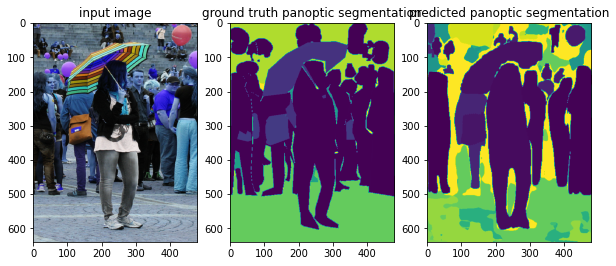

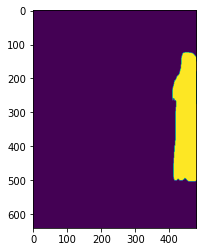

In [ ]:
image, panoptic_label, panoptic_segmentation_pred = get_prediction_panoptic(50)
print(np.unique(panoptic_label))
print(np.unique(panoptic_segmentation_pred))

plt.figure(figsize=(10,20))
plt.subplot(131)
image = torch.squeeze(image)
plt.imshow(image.numpy().transpose(1,2,0))
plt.title('input image')

plt.subplot(132)
plt.imshow(panoptic_label)
plt.title('ground truth panoptic segmentation')

plt.subplot(133)
plt.imshow(panoptic_segmentation_pred)
plt.title('predicted panoptic segmentation')
plt.show()

plt.imshow(panoptic_segmentation_pred==2)

In [ ]:
def segment_matching(target_segments,predicted_segments):

  matches = {}
  #the following two lists will be filled with matched segments
  gt_label_index=[]
  predicted_label_index=[]
  IOUs = []
  for i,target_segment in enumerate(target_segments['masks']):
    for j,predicted_segment in enumerate(predicted_segments['masks']):
      intersection = np.logical_and(target_segment,predicted_segment)
      intersection = np.sum(intersection)
      union = np.logical_or(target_segment,predicted_segment)
      union = np.sum(union)
      IOU = intersection / union

      if IOU>0.5:
        gt_label_index.append(i)
        predicted_label_index.append(j)
        IOUs.append(IOU*100)
        break 

  matches['gt_segment_index'] = gt_label_index
  matches['predicted_segment_index'] = predicted_label_index
  matches['IOU'] = IOUs
  return matches

In [ ]:
def calculate_panoptic_quality(matches,target_segments,predicted_segments):
  PQs = []

  for i in range(len(matches['gt_segment_index'])):
    IOU = matches['IOU'][i]
    #print(f"IOU: {IOU}")
    index_target = matches['gt_segment_index'][i]
    index_predicted = matches['predicted_segment_index'][i]

    TP = np.logical_and(target_segments['masks'][index_target],predicted_segments['masks'][index_predicted])
    TP = (TP == 1).sum()
    #print(f"TP: {TP}")
    FN = np.logical_and(target_segments['masks'][index_target],np.logical_not(predicted_segments['masks'][index_predicted]))
    FN = (FN==1).sum()
    #print(f"FN: {FN}")
    FP = np.logical_and(predicted_segments['masks'][index_predicted],np.logical_not(target_segments['masks'][index_target]))
    FP = (FP==1).sum()
    #print(f"FP  : {FP}")
    PQ = IOU / (TP + (0.5*FP) + (0.5*FN))
    PQs.append(PQ*100)

  PQ = sum(PQs)/(len(PQs)+1)
  return PQ

In [ ]:
PQs = []
for index in range(len(dataset_test_semantic)):

  image, panoptic_label, panoptic_prediction = get_prediction_panoptic(index)
  target_segments = get_segments(panoptic_label)
  predicted_segments = get_segments(panoptic_prediction)
  
  matches = segment_matching(target_segments,predicted_segments)  
  PQ = calculate_panoptic_quality(matches,target_segments,predicted_segments)
  PQs.append(PQ)
  
print(sum(PQs)/len(PQs))

0.7837315160636473
